<a href="https://colab.research.google.com/github/medhajoshi2503/Python/blob/main/IG_SimpleAutoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch

In [2]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5))
])

train_data = torchvision.datasets.MNIST('dataset/train', train=True,
                                        transform = transforms,
                                        download=True)

test_data = torchvision.datasets.MNIST('dataset/test', train=False,
                                        transform = transforms,
                                        download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 233718470.30it/s]

Extracting dataset/train/MNIST/raw/train-images-idx3-ubyte.gz to dataset/train/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 34017324.86it/s]


Extracting dataset/train/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 70890775.61it/s]


Extracting dataset/train/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18880603.34it/s]

Extracting dataset/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/train/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 219912149.02it/s]


Extracting dataset/test/MNIST/raw/train-images-idx3-ubyte.gz to dataset/test/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 20763745.94it/s]

Extracting dataset/test/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/test/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 77549802.61it/s]

Extracting dataset/test/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/test/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 5676558.04it/s]

Extracting dataset/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/test/MNIST/raw



In [3]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64
)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=64
)

In [4]:
train_data[0][0].numpy().shape

(1, 28, 28)

In [5]:
random_samples = np.random.randint(0,len(train_data), 25)

In [6]:
random_samples

array([44454, 13556, 26114, 25892, 15240, 42395, 56349, 33528, 37664,
           1, 52789, 10897, 25081, 40235, 15586, 17949, 31804, 19043,
       40558, 45991, 22384, 50620, 41078, 57700, 23770])

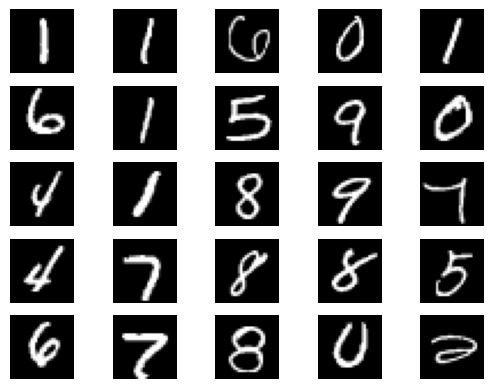

In [7]:
for i, img_indx in enumerate(random_samples):
  plt.subplot(5,5, i+1)
  plt.imshow(train_data[img_indx][0][0], cmap="gray")
  plt.axis('off')

plt.show()

In [8]:
class AutoEncoders(torch.nn.Module):
  def __init__(self, image_size=28):
    super().__init__()
    N = image_size ** 2 # 784 for MNIST data
    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(N, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 10),
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(10, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, N),
        torch.nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [9]:
model = AutoEncoders()

In [10]:
model.to('cuda')

AutoEncoders(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [11]:
!pip install torchview

In [12]:
# !pip install graphviz

In [13]:
import graphviz

graphviz.set_jupyter_format('png')

'svg'

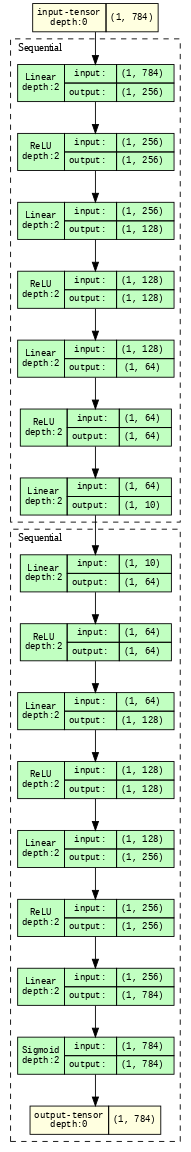

In [14]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1,28*28), expand_nested=True)
model_graph.visual_graph

In [15]:
from tqdm import tqdm

In [ ]:
model = AutoEncoders()
device = "cuda"
model.to(device)

optimization = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.MSELoss()

train_loss = []
epochs = 50

BATCH_SIZE = len(train_loader)

output = {}

for epoch in tqdm(range(epochs)):
  running_loss = 0.0
  model.to(device)
  for batch, (X, y) in enumerate(train_loader):
    # using _ for y variable, because we don't need it
    img, _ = X.to(device), y.to(device)
    img = img.reshape(-1, 28*28)
    out = model(img)
    loss = loss_fn(out, img)
    optimization.zero_grad()
    loss.backward()
    optimization.step()

    running_loss += loss.item()

  running_loss /= BATCH_SIZE
  train_loss.append(running_loss)
  print("\nEpoch : {}, Train Loss : {}".format(epoch, running_loss))

  output[epoch] = {'img' : img, 'out' : out}

  2%|▏         | 1/50 [00:17<14:10, 17.36s/it]


Epoch : 0, Train Loss : 0.9828999212174527


  4%|▍         | 2/50 [00:34<13:57, 17.46s/it]


Epoch : 1, Train Loss : 0.924591382175112


  6%|▌         | 3/50 [00:52<13:39, 17.44s/it]


Epoch : 2, Train Loss : 0.9200758577536926


  8%|▊         | 4/50 [01:11<13:46, 17.96s/it]


Epoch : 3, Train Loss : 0.9192627848211382


 10%|█         | 5/50 [01:29<13:34, 18.10s/it]


Epoch : 4, Train Loss : 0.9159386929418487


 12%|█▏        | 6/50 [01:46<12:59, 17.71s/it]


Epoch : 5, Train Loss : 0.9136972008610585


 14%|█▍        | 7/50 [02:04<12:44, 17.79s/it]


Epoch : 6, Train Loss : 0.9114032217434475


 16%|█▌        | 8/50 [02:21<12:20, 17.62s/it]


Epoch : 7, Train Loss : 0.9072428143609053


 18%|█▊        | 9/50 [02:39<12:06, 17.73s/it]


Epoch : 8, Train Loss : 0.9014627626582757


 20%|██        | 10/50 [02:56<11:41, 17.54s/it]


Epoch : 9, Train Loss : 0.8977812219784458


 22%|██▏       | 11/50 [03:13<11:21, 17.47s/it]


Epoch : 10, Train Loss : 0.8956099367345066


 24%|██▍       | 12/50 [03:32<11:19, 17.88s/it]


Epoch : 11, Train Loss : 0.8939831759502639


 26%|██▌       | 13/50 [03:56<12:03, 19.55s/it]


Epoch : 12, Train Loss : 0.8917342306200121


 28%|██▊       | 14/50 [04:14<11:29, 19.14s/it]


Epoch : 13, Train Loss : 0.8894048304573051


 30%|███       | 15/50 [04:32<10:54, 18.70s/it]


Epoch : 14, Train Loss : 0.88722182050951


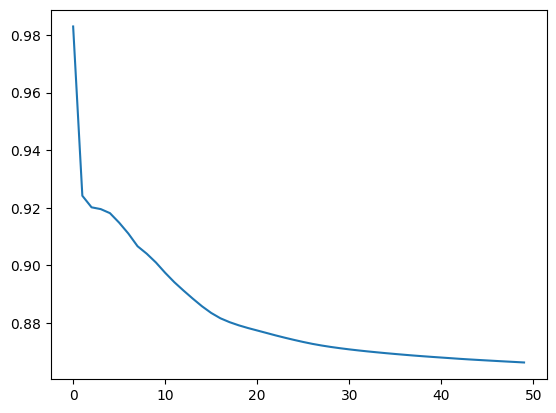

In [ ]:
plt.plot(train_loss)
plt.show()

In [ ]:
# output[0]

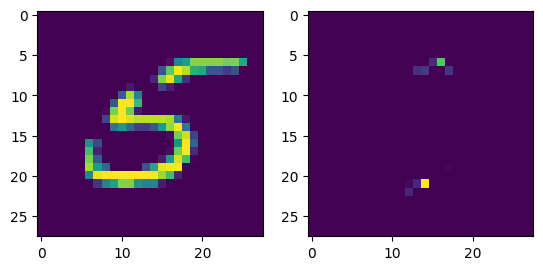

In [ ]:
plt.subplot(1,2,1)
plt.imshow(output[0]['img'][0].cpu().reshape(28, 28))
plt.subplot(1,2,2)
plt.imshow(output[0]['out'].cpu().detach().numpy()[0].reshape(28,28))
plt.show()

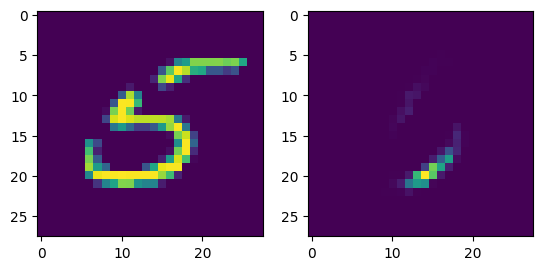

In [ ]:
plt.subplot(1,2,1)
plt.imshow(output[9]['img'][0].cpu().reshape(28, 28))
plt.subplot(1,2,2)
plt.imshow(output[9]['out'].cpu().detach().numpy()[0].reshape(28,28))
plt.show()

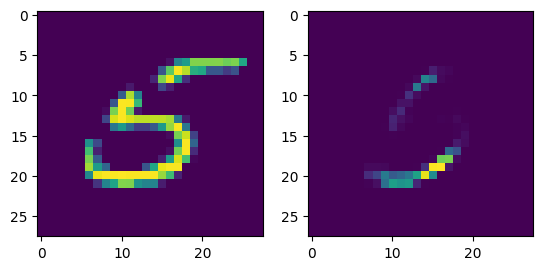

In [ ]:
plt.subplot(1,2,1)
plt.imshow(output[49]['img'][0].cpu().reshape(28, 28))
plt.subplot(1,2,2)
plt.imshow(output[49]['out'].cpu().detach().numpy()[0].reshape(28,28))
plt.show()